# Create train-test-validation splits (for promiscuous esterases)

Here, I basically do the same as in N2_curate_training_data.ipynb but I do it for the combined training and validation data to later make my own train-test splits. 

In [16]:
import pandas as pd

df_train = pd.read_csv('/nvme2/helen/masterthesis/manuscript/data/EnzymeCAGE_train.csv')
df_valid = pd.read_csv('/nvme2/helen/masterthesis/manuscript/data/EnzymeCAGE_valid.csv',  low_memory=False)
df_protein = pd.read_pickle('/home/helen/cec_degrader/generalize/data/protein.pkl')

# Combine validation and training data
df_CAGE = pd.concat([df_train, df_valid], axis=0).reset_index(drop=True)

### Filter down to all promiscuous enzymes

In [19]:
# Positive samples only
df = df_CAGE[df_CAGE['Label'] == 1]

# Add EC number from protein.pkl if not present 
ec_mapping = df_protein.groupby('Entry')['EC number'].apply(list).to_dict()
df['EC number'] = df['UniprotID'].map(ec_mapping)
df['EC number'] = df['EC number'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Filter to (catalytically) promiscuous enzymes (i.e. present more than once in df)
filtered_df = df[df['UniprotID'].duplicated(keep=False)]
df  = filtered_df.sort_values(by='UniprotID')
df = df.reset_index(drop=True)

# Split reaction SMILEs into substrates and products
df[['substrates', 'products']] = df['SMILES'].str.split('>>', expand=True)

# Remove H20 and H+ as a substrate
def remove_water_and_protons(smiles):
    if pd.isna(smiles):
        return smiles
    parts = smiles.split('.')
    parts = [p for p in parts if p not in ('[H]O[H]', '[H+]', '[H]')]
    return '.'.join(parts)

# Number of substrates and products per entry
df['number_substrates'] = df['substrates'].str.count('\.') + 1
df['number_products'] = df['products'].str.count('\.') + 1


<>:26: SyntaxWarning: invalid escape sequence '\.'
<>:27: SyntaxWarning: invalid escape sequence '\.'
<>:26: SyntaxWarning: invalid escape sequence '\.'
<>:27: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_2200145/1737536734.py:26: SyntaxWarning: invalid escape sequence '\.'
  df['number_substrates'] = df['substrates'].str.count('\.') + 1
/tmp/ipykernel_2200145/1737536734.py:27: SyntaxWarning: invalid escape sequence '\.'
  df['number_products'] = df['products'].str.count('\.') + 1
/tmp/ipykernel_2200145/1737536734.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EC number'] = df['UniprotID'].map(ec_mapping)
/tmp/ipykernel_2200145/1737536734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

### Filter down to all substrate promiscuous enzymes

In [21]:

# Create cannonical substrate strings to detect duplicate substrates 
def canonical_substrates(substrates):
    parts = substrates.split('.')
    parts = sorted([p.strip() for p in parts])
    return '.'.join(parts)

df['substrates_canonical'] = df['substrates'].str.strip().apply(canonical_substrates)

# For each UniprotID, remove catalytically promiscuous enzymes by filtering out rows with identical substrates
def filter_unique_substrates(group):
    counts = group['substrates_canonical'].value_counts()
    unique_substrates = counts[counts == 1].index
    return group[group['substrates_canonical'].isin(unique_substrates)]

df_unique = df.groupby('UniprotID', group_keys=False).apply(filter_unique_substrates).reset_index(drop=True)
df_unique = df_unique.drop(columns=['substrates_canonical'])
df_unique = df_unique[df_unique['UniprotID'].duplicated(keep=False)]
df_unique = df_unique.sort_values(by='UniprotID')

# Split substrate SMILES into seperate entries
df_unique['substrates_split'] = df_unique['substrates'].str.split('.')
df_unique = df_unique.explode('substrates_split').reset_index(drop=True)
df_unique.loc[df_unique['number_substrates'] > 1]

# For each UniprotID, remove the substrates that are common to all RHEA_IDs within the same UniprotID. The logic being that these do not contribute to promiscuity because stay constant in all reactions. 
substrate_rhea_counts = df_unique.groupby(['UniprotID', 'substrates_split'])['RHEA_ID'].nunique().reset_index(name='rhea_count')
total_rhea_counts = df_unique.groupby('UniprotID')['RHEA_ID'].nunique().reset_index(name='total_rhea_count') # Find the total number of unique RHEA_IDs for each UniprotID
merged = pd.merge(substrate_rhea_counts, total_rhea_counts, on='UniprotID')
merged['appear_in_all_rhea'] = merged['rhea_count'] == merged['total_rhea_count']
substrates_to_remove = merged[merged['appear_in_all_rhea'] == True]

df_filtered = df_unique.merge(substrates_to_remove[['UniprotID', 'substrates_split']], 
                       on=['UniprotID', 'substrates_split'], how='left', indicator=True)

df = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])

# 132'620 entries

/tmp/ipykernel_2200145/1277239466.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_unique = df.groupby('UniprotID', group_keys=False).apply(filter_unique_substrates).reset_index(drop=True)


### Filder down to promiscous esterases with EC 3.1.

In [24]:
import pandas as pd

# Filter to only promiscuous esterases
uniprot_with_3_1 = df.loc[df['EC number'].fillna('').str.startswith('3.1.'), 'UniprotID'].unique()
df_filtered = df[df['UniprotID'].isin(uniprot_with_3_1)].copy()
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.to_pickle('/nvme2/helen/masterthesis/manuscript/data/EnzymeCAGE_train_valid_promiscuous_substrates_EC3p1.pkl')

# 10'354   entries
# Contains all substrate promiscuous enzymes with EC 3.1 having removed catalytically promiscuous enzymes. 

### Run MMSeqs2 on promiscuous esterases

In [ ]:
import sys
sys.path.append('/home/helen/enzyme-tk/enzymetk')
from enzymetk.similarity_mmseqs_step import MMseqs
from enzymetk.save_step import Save
import pandas as pd

# run in enzymetk environment
df_promis_esterases = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/data/EnzymeCAGE_train_valid_promiscuous_substrates_EC3p1.pkl')
id_col = 'UniprotID'
seq_col = 'sequence'
output_dir = 'mmseqs2/'

df_promis_esterases << (MMseqs(id_col, seq_col, tmp_dir=output_dir, method='cluster',  args=['--min-seq-id', '0.8', '-c', '0.9', '--cov-mode', '1']) >> Save(f'{output_dir}promiscuous_esterases_train_valid_mmseqs2_0p9_similarity.pkl'))

### Split into train-validate-test sets

In [19]:
import random

df = pd.read_pickle('mmseqs2/promiscuous_esterases_train_valid_mmseqs2_0p9_similarity.pkl')

# Group by clusters
clustered_groups = df.groupby('mmseqs_representative_cluster_seq')
all_clusters = list(clustered_groups.groups.keys())

# Shuffle and split clusters
random.seed(42)
random.shuffle(all_clusters)
n_total = len(all_clusters)
n_train = int(n_total * 0.8)
n_val = int(n_total * 0.1)

train_clusters = all_clusters[:n_train]
val_clusters = all_clusters[n_train:n_train + n_val]
test_clusters = all_clusters[n_train + n_val:]

# Assign sequences to splits 
df['split'] = 'none'
df.loc[df['mmseqs_representative_cluster_seq'].isin(train_clusters), 'split'] = 'train'
df.loc[df['mmseqs_representative_cluster_seq'].isin(val_clusters), 'split'] = 'val'
df.loc[df['mmseqs_representative_cluster_seq'].isin(test_clusters), 'split'] = 'test'
print(df['split'].value_counts())

df_train = df[df['split'] == 'train'].reset_index(drop=True)
df_val = df[df['split'] == 'val'].reset_index(drop=True)
df_test = df[df['split'] == 'test'].reset_index(drop=True)

train    8158
val      1247
test      949
Name: split, dtype: int64


In [ ]:
# Plot pie-charts of EC class distribution
import pandas as pd
import matplotlib.pyplot as plt

def plot_ec_class_pie_chart(df, ec_column='EC number', ec_level=3, title='EC Class Distribution'):
    """
    Plots a pie chart of enzyme counts grouped by the first `ec_level` digits of EC numbers.
    """
    df = df[df[ec_column].notna()]

    # Extract EC prefix
    df['EC_prefix'] = df[ec_column].apply(
        lambda x: '.'.join(x.split('.')[:ec_level]) if isinstance(x, str) else None
    )

    # Count frequency of each EC prefix
    ec_counts = df['EC_prefix'].value_counts().sort_index()

    plt.figure(figsize=(10, 8))
    plt.pie(ec_counts, labels=ec_counts.index, autopct='%1.1f%%', startangle=140, counterclock=False)
    plt.title(title + f" (First {ec_level} Digits)")
    plt.axis('equal')
    plt.show()

plot_ec_class_pie_chart(df_train, ec_column='EC number', ec_level=3, title = 'EC Class distribution in df_train')
plot_ec_class_pie_chart(df_test, ec_column='EC number', ec_level=3, title = 'EC Class distribution in df_test')
plot_ec_class_pie_chart(df_val, ec_column='EC number', ec_level=3, title = 'EC Class distribution in df_val')

/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=9.
  warnings.warn(


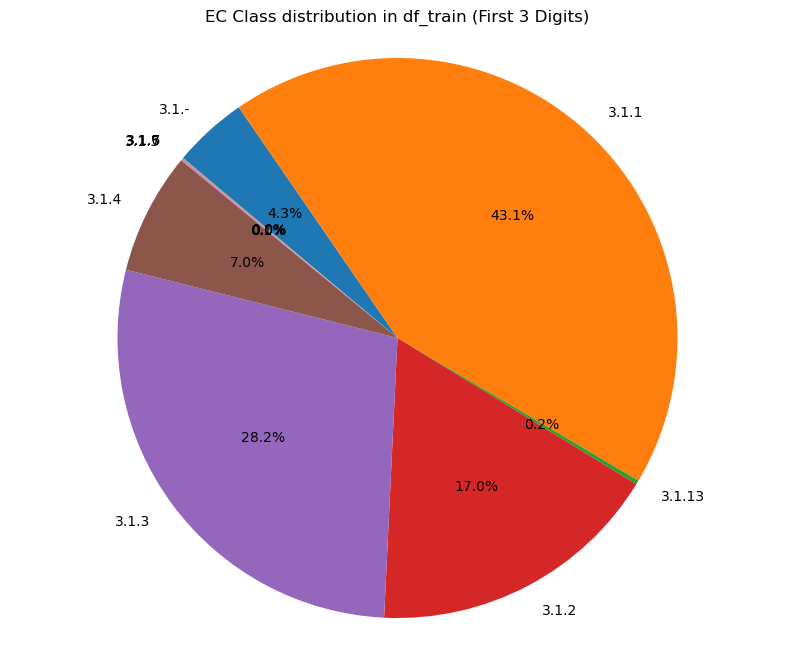

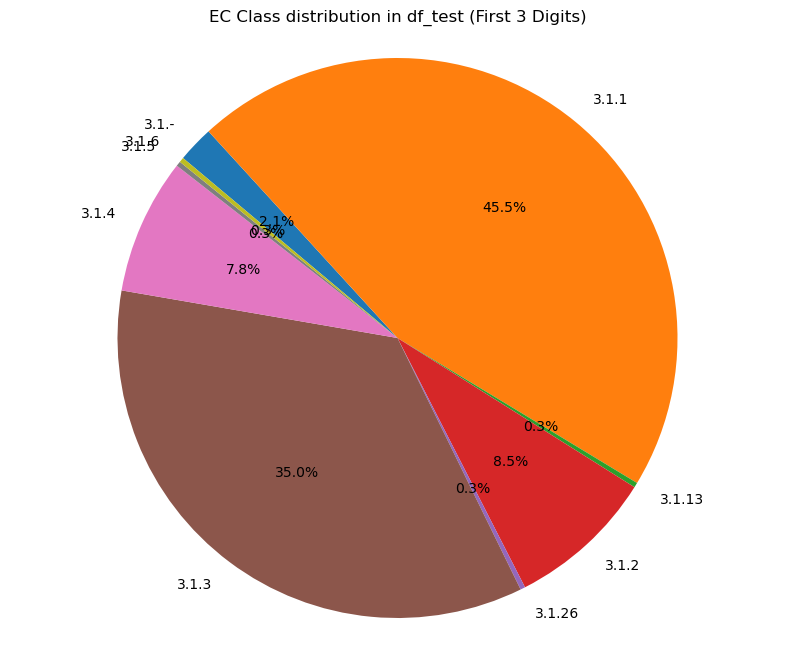

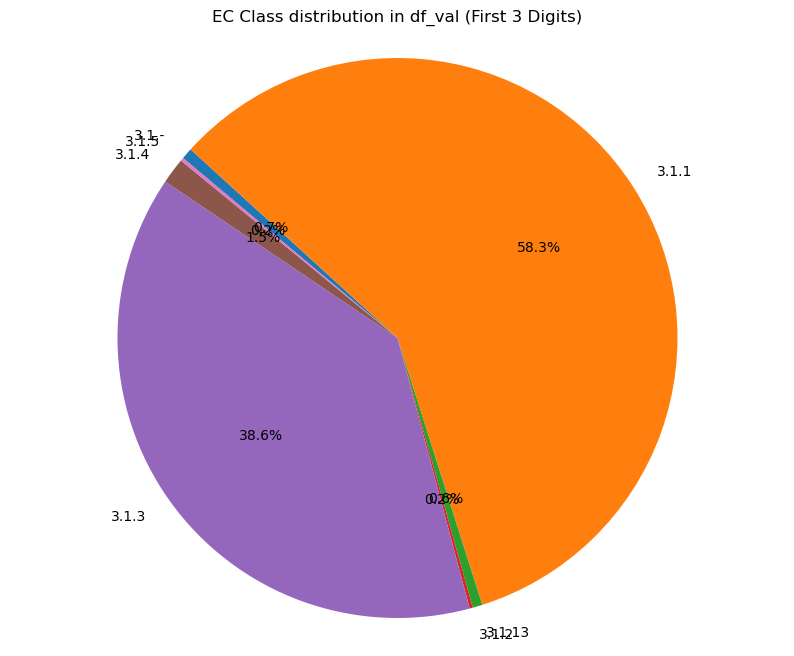

In [33]:
from sklearn.model_selection import StratifiedGroupKFold
import pandas as pd

def stratified_group_split(df, label_col, group_col, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Split ratios must sum to 1."

    sgkf = StratifiedGroupKFold(n_splits=int(1 / test_size), shuffle=True, random_state=random_state)

    # First split: train + val vs test
    for train_val_idx, test_idx in sgkf.split(df, y=df[label_col], groups=df[group_col]):
        df_train_val = df.iloc[train_val_idx].copy()
        df_test_stratified = df.iloc[test_idx].copy()
        break  # only take the first split

    # Second split: train vs val within train_val
    val_ratio = val_size / (train_size + val_size)
    sgkf_val = StratifiedGroupKFold(n_splits=int(1 / val_ratio), shuffle=True, random_state=random_state + 1)
    for train_idx, val_idx in sgkf_val.split(df_train_val, y=df_train_val[label_col], groups=df_train_val[group_col]):
        df_train_stratified = df_train_val.iloc[train_idx].copy()
        df_val_stratified = df_train_val.iloc[val_idx].copy()
        break  # only take the first split

    return df_train_stratified.reset_index(drop=True), df_val_stratified.reset_index(drop=True), df_test_stratified.reset_index(drop=True)

df_train_stratified, df_val_stratified, df_test_stratified = stratified_group_split(df, label_col='EC number', group_col = 'mmseqs_representative_cluster_seq')

plot_ec_class_pie_chart(df_train_stratified, ec_column='EC number', ec_level=3, title = 'EC Class distribution in df_train')
plot_ec_class_pie_chart(df_test_stratified, ec_column='EC number', ec_level=3, title = 'EC Class distribution in df_test')
plot_ec_class_pie_chart(df_val_stratified, ec_column='EC number', ec_level=3, title = 'EC Class distribution in df_val')